<a href="https://colab.research.google.com/github/project4sharing/exp_credit_card_fraud/blob/initial/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Topic - High Level Exercise Goal
This project is a Credit Card Fraud experiment leveraging credit card transaction data to train a classification model that will predict if unseen transaction data will be a fraudulent transacation or not.  

Although different types of electronic payment methods have evolved over time, credit card payment method still takes on a significant portion of all the payment volume.  Because of this, credit card fraud detection is still very much relevant to payment processor and potential (predicted) fraudulent charge could be stopped or confirmed by the card holder (transaction held until card holder confirms purchase).  This is a very common scenario that a lot of us may have experienced and that's also the reason why I choose this data source for my learning journey.

The objective of this ML exercise is to:  
1. Train a surpervised learning classification model (learning from labelled data)
2. Determine if future "unseen" credit card transaction is "potentially" fradulent
3.  Exercise "muscle memory" of common Machine Learning (ML) best practice:
*   Data wangling & cleaning
*   Exploratory data analysis (EDA)
*   Feature treatments
*   Model performance and selection
*   Presentation of discovery




# Data - Data Sources
Credit Card Fraud data source hosted in Kaggle contributed by Dhanush NaraYanan R.

https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data

This data source is licensed under "CC0: Publich Domain".

Data source is a single ~76Mb data file and containes 1MM samples of 8 features:
1. distance_from_home - numberic - Distance from credit card registration address
2. distance_from_last_transaction - numeric - Distance of the current transation from the previous transaction on the same credit card
3. ratio_to_median_purchase_price - numeric - Ratio of current charge to median purchase price
4. repeat_retailer - categorical - current charge made to frequent store / retailer
5. used_chip - categorical - IC chip used to authorize charge
6. used_pin_number - categorical - PIN used to authorize charge
7. online_order - categorical - current charge made for online purchase
8. fraud - categorical - prediction of whether charge may be fraudulent - this is the target variable that we would like to predict

At a first glance, the initial intuition is feature #1, #2, #5, #6 are "card present" type of purchases, ie, card holder makes purchase in person.

# Preparation / Initialization

1. To make this notebook more self-contained (and tried to avoid storing my Kaggle API key for download in the notebook -- a bad practice), I copied the data to my Google drive.

2. For similar reason, I will also initialize values for the reproducibility of this notebook

In [1]:
random_seed = 202406

# Acquire Additional Packages
Acquire additional Python packages that may not be readily available in the Jupyter notebook environment (in this case Google Colab)

Packages list:


*   gdown - Used to download credit card transacation data stored in Google drive (card-transdata.csv)



In [2]:
# Acquire prerequisite packages
!pip install gdown
!pip install imbalanced-learn

In [27]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTENC

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import gdown

In [4]:
gdown.download('https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo', 'card_transdata.csv')

Downloading...
From: https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo
To: /content/card_transdata.csv
100%|██████████| 76.3M/76.3M [00:00<00:00, 81.7MB/s]


'card_transdata.csv'

Load raw data file into a dataframe

In [5]:
df_credit_card_fraud_org = pd.read_csv('./card_transdata.csv', sep=',', header=0, index_col=False, engine='python')

# Data - Basic Data Understanding

*   From DF.info() & describe(), I acquire some basic understanding of the data:
  *   the data set shape is a 100k x 8 tabular data, all features are of numeric type and there is **no missing data** based on the reported number of occurence of all the attributes including the fraud label
  *   all of the features are already numeric, even the categorical features like: a) used_chip; b) used_pin_number; c) online_order; d) repeat_retailer and ***they are all of binary type of categorical feature, ie, True / False; therefore, there is NO need to further apply feature encoding techniques, like one-hot encoder, to encode them***

Use df.info() to learn:
1. Shape of dataframe
2. Data type of each feature & label
3. Any missing data data

Use df.drop_duplicates() to confirm no duplicate rows.

In [6]:
df_credit_card_fraud_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


Use df.describe() to learn unusual charasteristics hidden in the data:
1. Any anonmalies / outliers
2. Imbalance data set


In [7]:
df_credit_card_fraud_org.describe(include='all', percentiles=[0.25, 0.5, 0.75, 0.9, 0.93, 0.95, 0.99])

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
90%,60.268980,10.008053,4.080939,1.000000,1.000000,1.000000,1.000000,0.000000
93%,78.908923,14.146703,5.050214,1.000000,1.000000,1.000000,1.000000,1.000000
95%,99.708638,19.170549,6.071425,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Confirm if there are duplicate rows

count_before = df_credit_card_fraud_org.shape[0]
count_after = df_credit_card_fraud_org.drop_duplicates().shape[0]
print(f"Dataset length before:{count_before}, after:{count_after}")
print("No duplicate rows found...")

Dataset length before:1000000, after:1000000
No duplicate rows found...


For quick data value density:

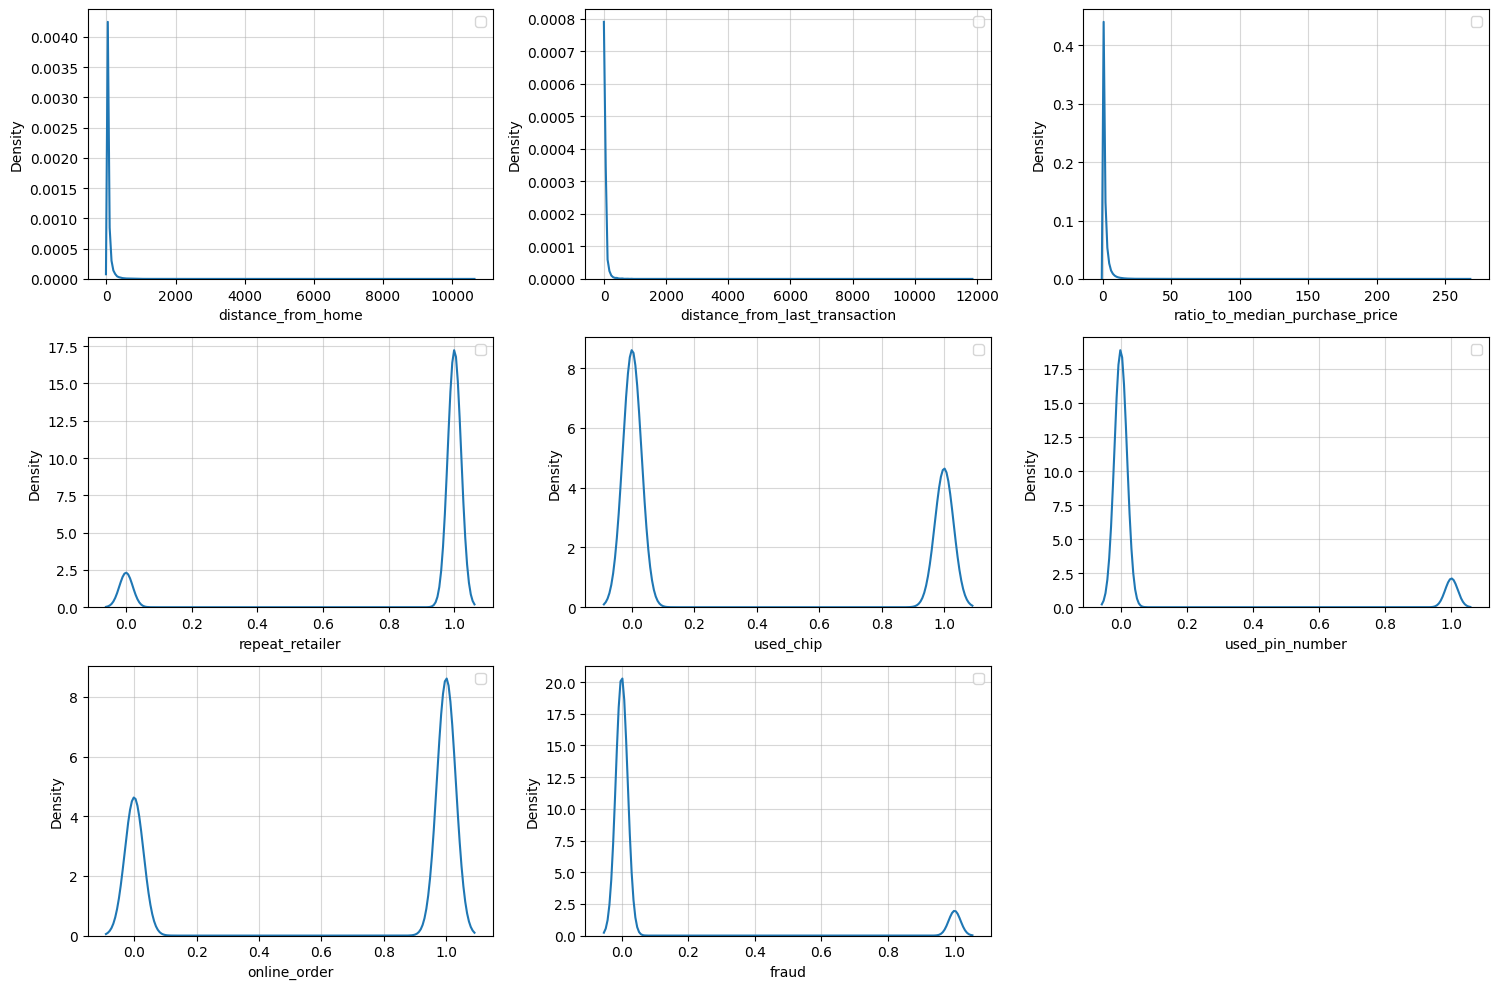

In [9]:
fig = plt.figure(figsize=(15, 10))
rows, cols = 3, 3
for i, col_name in enumerate(df_credit_card_fraud_org.loc[:, 'distance_from_home' : 'fraud'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = df_credit_card_fraud_org)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()

# Data Cleaning - Overcome Train/Test Split Challenge by Creating New Feature based on used_chip & used_pin_number

As demonstrated in the density graph, we observe the categorical features are somewhat skewed, so we need to ensure the "stratify" feature in train_test_split is leveraged to make sure the same skewness is preserved in the train/test datasets.

However, if I include all 5 original categorical features (even with a low test sample size out of 1MM samples), it will report error since the stratificaion strategy can't find a "good" data split that satisfy all the "Train/Test" requirements, ie, a split that maintains all the observed data value proportions

Because of this discovery, I create a new feature, called "card_present", based on the 2 features "used_chip" and "used_pin_number" as they both are considered as "card present" transaction, ie, the card holder/card is present at the point of sales (POS).

|  card_present  |  used_chip  |  used_pin_number  |
| -------------- | ----------- | ----------------- |
|       0        |    False    |     False         |
|       1        |    False    |     True          |
|       1        |    True     |     False         |
|       1        |    True     |     True          |

After this step, train / test split becomes successful.  A new feature called "id" is added to the dataset and it is a just a copy of the dataframe index.  After the train/test split becomes successful, we will leverage this "id" field and retrieve the rows from the original dataset.

In [18]:
print(df_credit_card_fraud_org['repeat_retailer'].value_counts())
print(df_credit_card_fraud_org['used_chip'].value_counts())
print(df_credit_card_fraud_org['used_pin_number'].value_counts())
print(df_credit_card_fraud_org['online_order'].value_counts())
print(df_credit_card_fraud_org['fraud'].value_counts())

dX = df_credit_card_fraud_org.loc[:, ~df_credit_card_fraud_org.columns.isin(["fraud"])].copy()
dY = df_credit_card_fraud_org['fraud']

# If we try to maintain all the categorical feature's proportions, the train/test split will fail
X_train, X_test, Y_train, Y_test = train_test_split(dX, dY, test_size=50, random_state=random_seed, shuffle=True, stratify=df_credit_card_fraud_org[['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']])

repeat_retailer
1.0    881536
0.0    118464
Name: count, dtype: int64
used_chip
0.0    649601
1.0    350399
Name: count, dtype: int64
used_pin_number
0.0    899392
1.0    100608
Name: count, dtype: int64
online_order
1.0    650552
0.0    349448
Name: count, dtype: int64
fraud
0.0    912597
1.0     87403
Name: count, dtype: int64


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [19]:
# 1. Make a copy of the original dataset
# 2. Create card_present feature.  card_present feature is a combination of used_chip & used_pin_number features as they both will only be true when the card holder/card is present
# 3. Drop the used_chip & used_pin_number features from this intermediate dataset

df_credit_card_fraud_cleaned_stratification_step01 = df_credit_card_fraud_org.copy()

df_credit_card_fraud_cleaned_stratification_step01['card_present'] = df_credit_card_fraud_cleaned_stratification_step01[['used_chip', 'used_pin_number']].max(axis=1)
df_credit_card_fraud_cleaned_stratification_step01.drop(columns=['used_chip', 'used_pin_number'], inplace=True)

df_credit_card_fraud_cleaned_stratification_step01.head(20)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,online_order,fraud,card_present
0,57.877857,0.311140,1.945940,1.0,0.0,0.0,1.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,1.0,0.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,1.0,0.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,0.0,1.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,1.0,0.0,0.0


In [20]:
# With the new card_present feature, the train/test split is successful

# dX = df_credit_card_fraud_cleaned_stratification_step01.loc[:, ~df_credit_card_fraud_cleaned_stratification_step01.columns.isin(["fraud"])].copy()
# dY = df_credit_card_fraud_cleaned_stratification_step01.loc[:, ['fraud']].copy()

X_train, X_test, Y_train, Y_test = train_test_split(dX, dY, test_size=0.1, random_state=random_seed, shuffle=True, stratify=df_credit_card_fraud_cleaned_stratification_step01[['repeat_retailer', 'online_order', 'card_present', 'fraud']])


# Data Cleaning - Overcome Imbalance Data Challenge by Applying SMOTE Technique

Valid tx count:912597, Fraudulent tx count: 87403


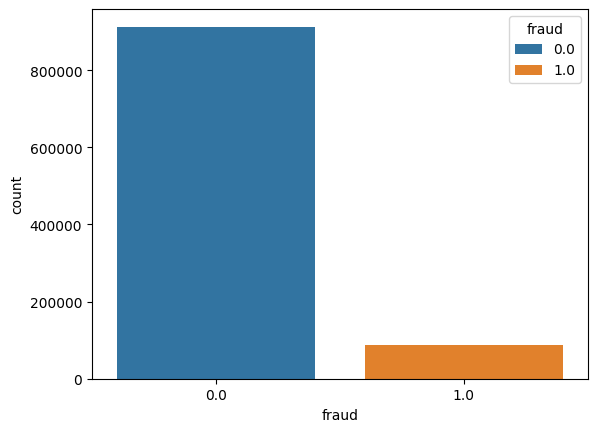

In [26]:
fraud_count = df_credit_card_fraud_org["fraud"].value_counts().tolist()
print(f"Valid tx count:{fraud_count[0]}, Fraudulent tx count: {fraud_count[1]}")

sns.countplot(x = 'fraud', data = df_credit_card_fraud_org, hue='fraud', stat='count', legend='auto')
plt.show()

#### Data Cleaning - Fix imbalance data

As the previous diagram confirms our observation from df.describe() and common intuition, the data is imbalance.  With fraudulent ratio around ~9.578%, even without a model, we will be able to guess >90% that a transaction isn't fraudulent.

To fix it, we can either choose under-sampling or over-sampling.  However, since the majority of the dataset are "valid" transactions, if we take the under-sampling route, it will significantly lower the overall data population size and it can potentially drop useful data too, so I think over-sampling will be a better route, ie, the minority data is artifically re-introduced into the dataset for training purpose.

However, after further research, I found out there is a technique called "Synthetic Minority Over-sampling Technique", aka "SMOTE", published by N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer at https://arxiv.org/abs/1106.1813.

Even better, the technique has been implemented in Python package called "imbalanced-learn" at https://imbalanced-learn.org/stable/index.html as a result of "Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning" by Guillaume Lemaître, Fernando Nogueira, Christos K. Aridas.

This technique's goal is aimed at improving the performance of the model, so this technique will only be applied to the training dataset (e.g. X_train)







In [42]:
print(X_train.columns)

cat_feature_index = X_train.columns.get_indexer(['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order'])
print(cat_feature_index)

# create new X/Y_train and call them X_oversampled
smotenc = SMOTENC(cat_feature_index, random_state=random_seed)
X_oversampled, Y_oversampled = smotenc.fit_resample(X_train, Y_train)



Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order'],
      dtype='object')
[3 4 5 6]


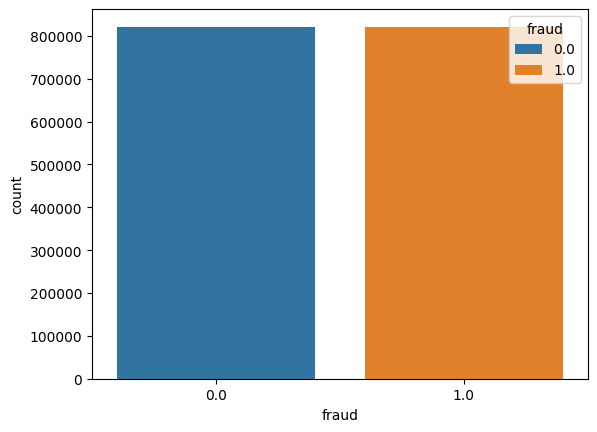

In [44]:
# Validate the population of the new oversampled dataset

sns.countplot(x = 'fraud', data = Y_oversampled.to_frame(), hue='fraud', stat='count', legend='auto')
plt.show()

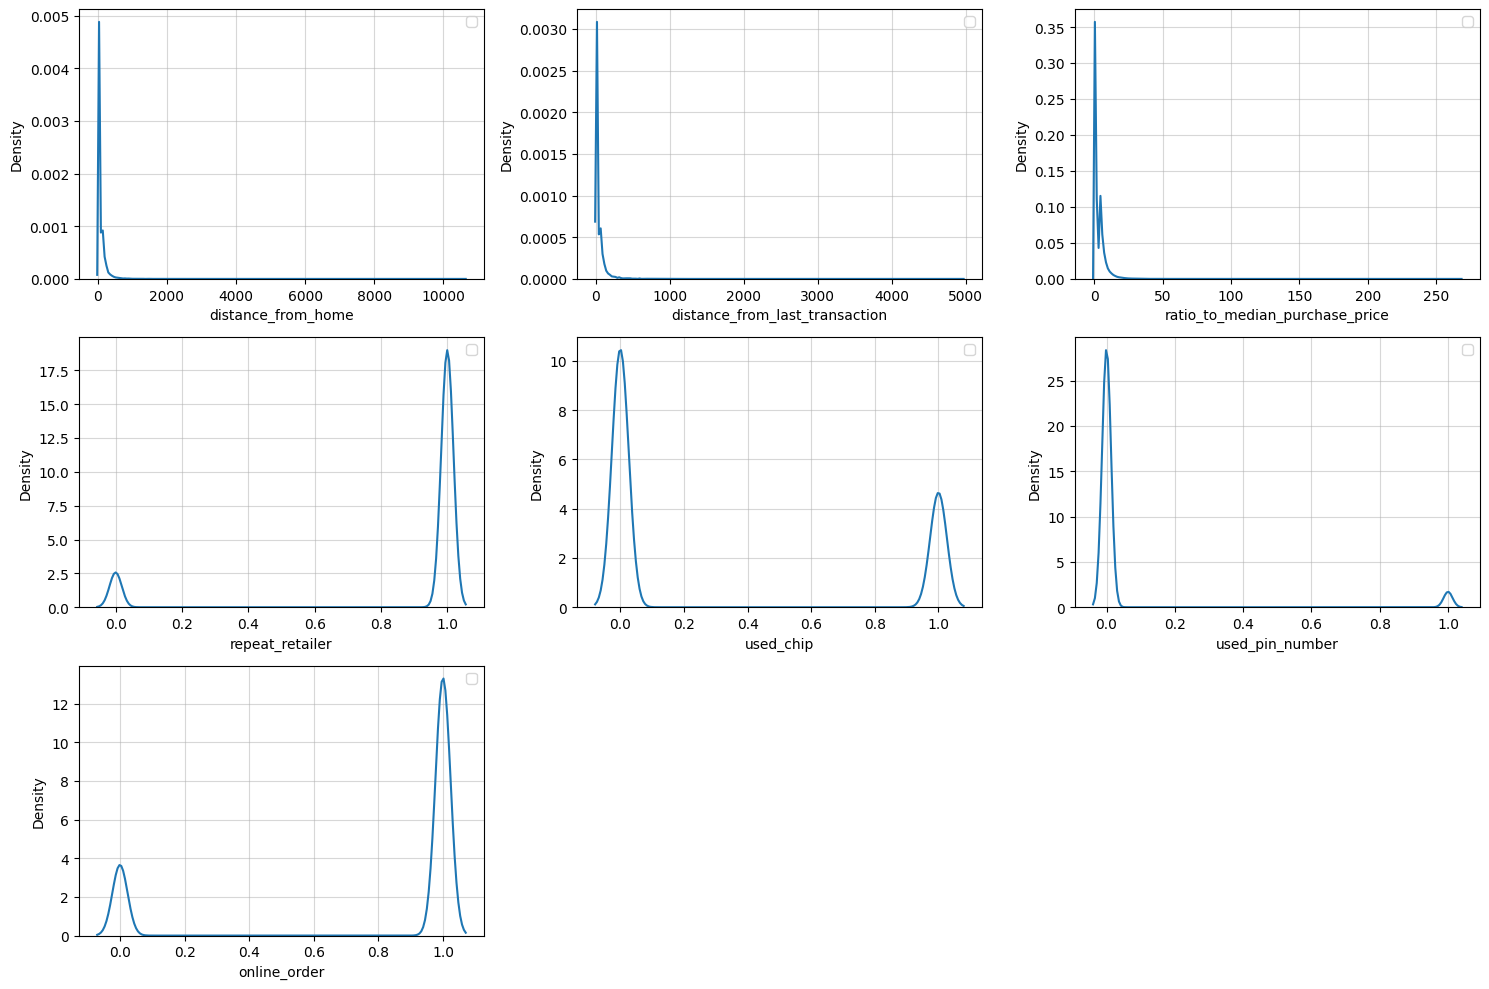

In [52]:
# Spot check the density of the new X_oversampled dataset

fig = plt.figure(figsize=(15, 10))
rows, cols = 3, 3
for i, col_name in enumerate(X_oversampled.loc[:, 'distance_from_home' : 'online_order'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = X_oversampled)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()

# Data Cleaning - Overcome Data Scale Challenge by Using Logarithm Method

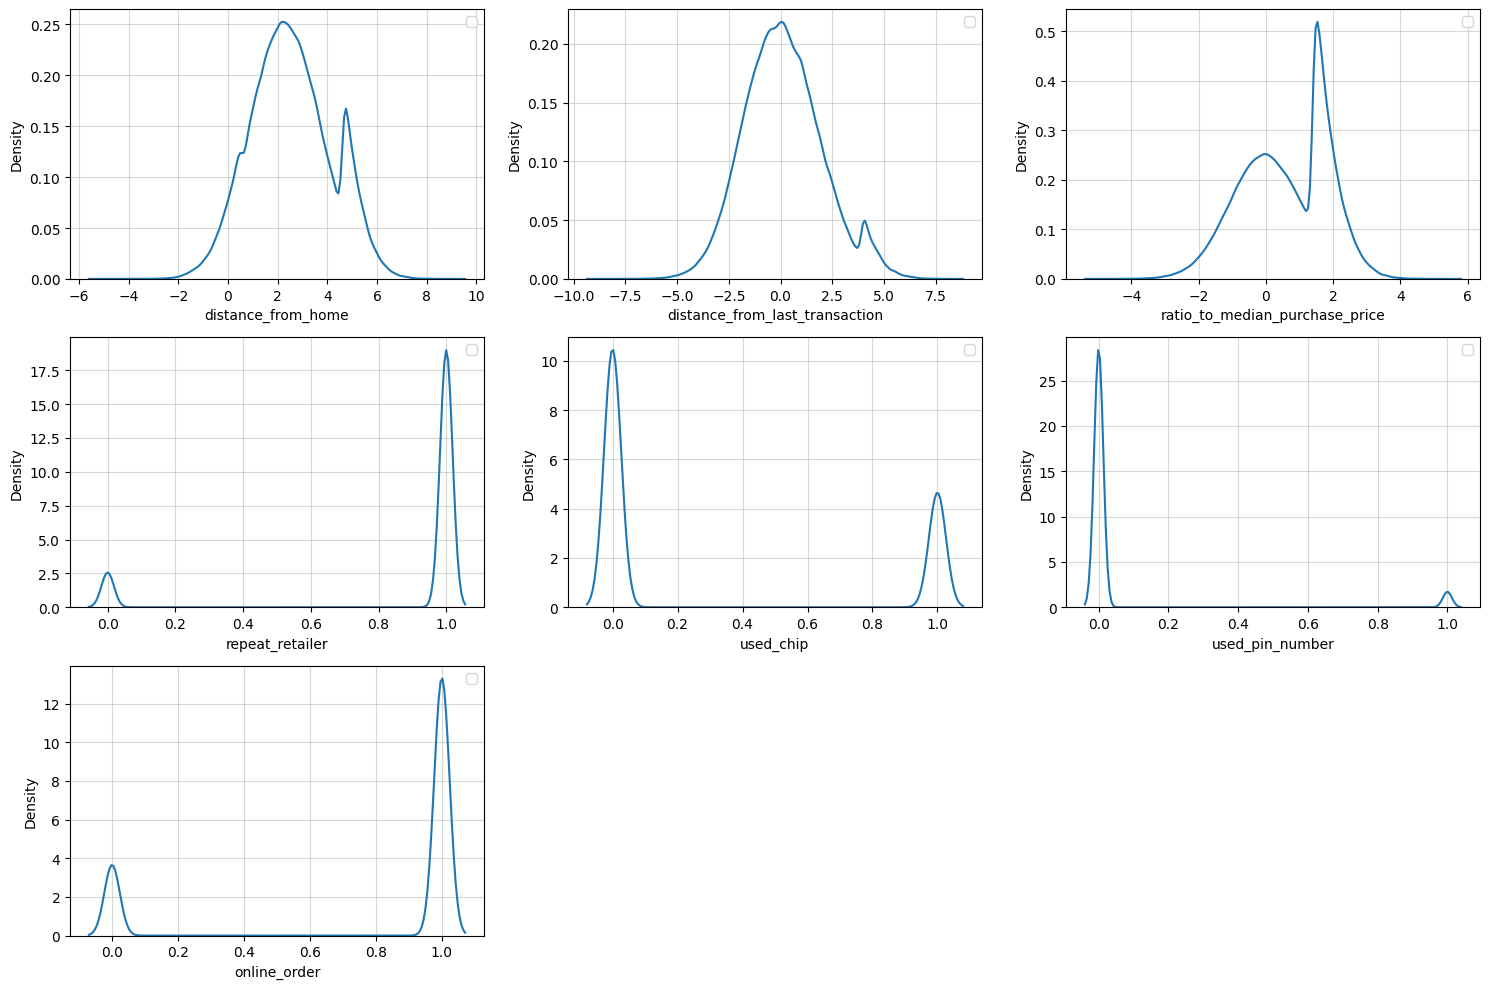

In [53]:
# Apply Logarithm to the "distance_from_home", "distance_from_last_transation" and "ratio_to_median_purchase_price" features

X_oversampled['distance_from_home'] = np.log(X_oversampled['distance_from_home'])
X_oversampled['distance_from_last_transaction'] = np.log(X_oversampled['distance_from_last_transaction'])
X_oversampled['ratio_to_median_purchase_price'] = np.log(X_oversampled['ratio_to_median_purchase_price'])

# Spot check the density of the new X_oversampled dataset, and the charts confirmed the "tails" are "pulled" back

fig = plt.figure(figsize=(15, 10))
rows, cols = 3, 3
for i, col_name in enumerate(X_oversampled.loc[:, 'distance_from_home' : 'online_order'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = X_oversampled)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()

# Data Cleaning - Unforseen Problems / Conclusion

Unforseen challenge:
1. Test / Train split stratification error

*   If I include all 5 original categorical features and with a typical 0.2 test size, then it will report error since the stratificaion strategy can't find a "good" data split that satisfy all the Train / Test requirements, ie, train / test size, all the features that need to be stratified and all the observed data value proportions
*   Because of this discovery, we have to create a new feature to complete the train/test split step

Forseen challenge:
2.  Fraud occurence is expected to be minority
*    Over-sampling technique is needed
*    SMOTE is a better approach compared to the traditional "random" over-sampling technique

3.  From the density charts, the continuous features "distance_from_home", "distance_from_last_transation" and "ratio_to_median_purchase_price" are right-skewed

*    As the range is beyond 99% percentile, I applied the Logarithm method to these features and successfully "pull" the tails towards the center
*    With this scaling, we are ready for various classification algorithms that are "sensitive" to the scale / range of the continuous features



# **Exploratory Data Analysis - High Level "To-Do"s**

Perform the following tasks to further data understanding:


1.   Feature Distribution Analysis - this step demonstrate the distrubtion of the data values so as to determine if there are any data value anomalies that require special treatment
2.   Correlation Analysis - this step determines the relationships among the various features so as to determin if there is/are irrelevant features which introduces noise and negatively impact model performance and should be dropped





# **Exploratory Data Analysis (EDA)**

Perform the following tasks to further data understanding:


1.   From the diagrams, we observe "long tails" and, in terms of order of magnitude, they are sigifnicant different from the other features, so this indicates that we need to decide proper treatment like normalization of the features values as algorithm like Logistical Regression is sensitive to the scale of the features


*   distance_from_home
*   distance_from_last_transaction
*   ratio_to_median_purchase_price


2.  The other features are all categorical of True / False, and from the diagrams, we may need to handle this "imbalance" characteristic of the features




# EDA - Check for correlation among features


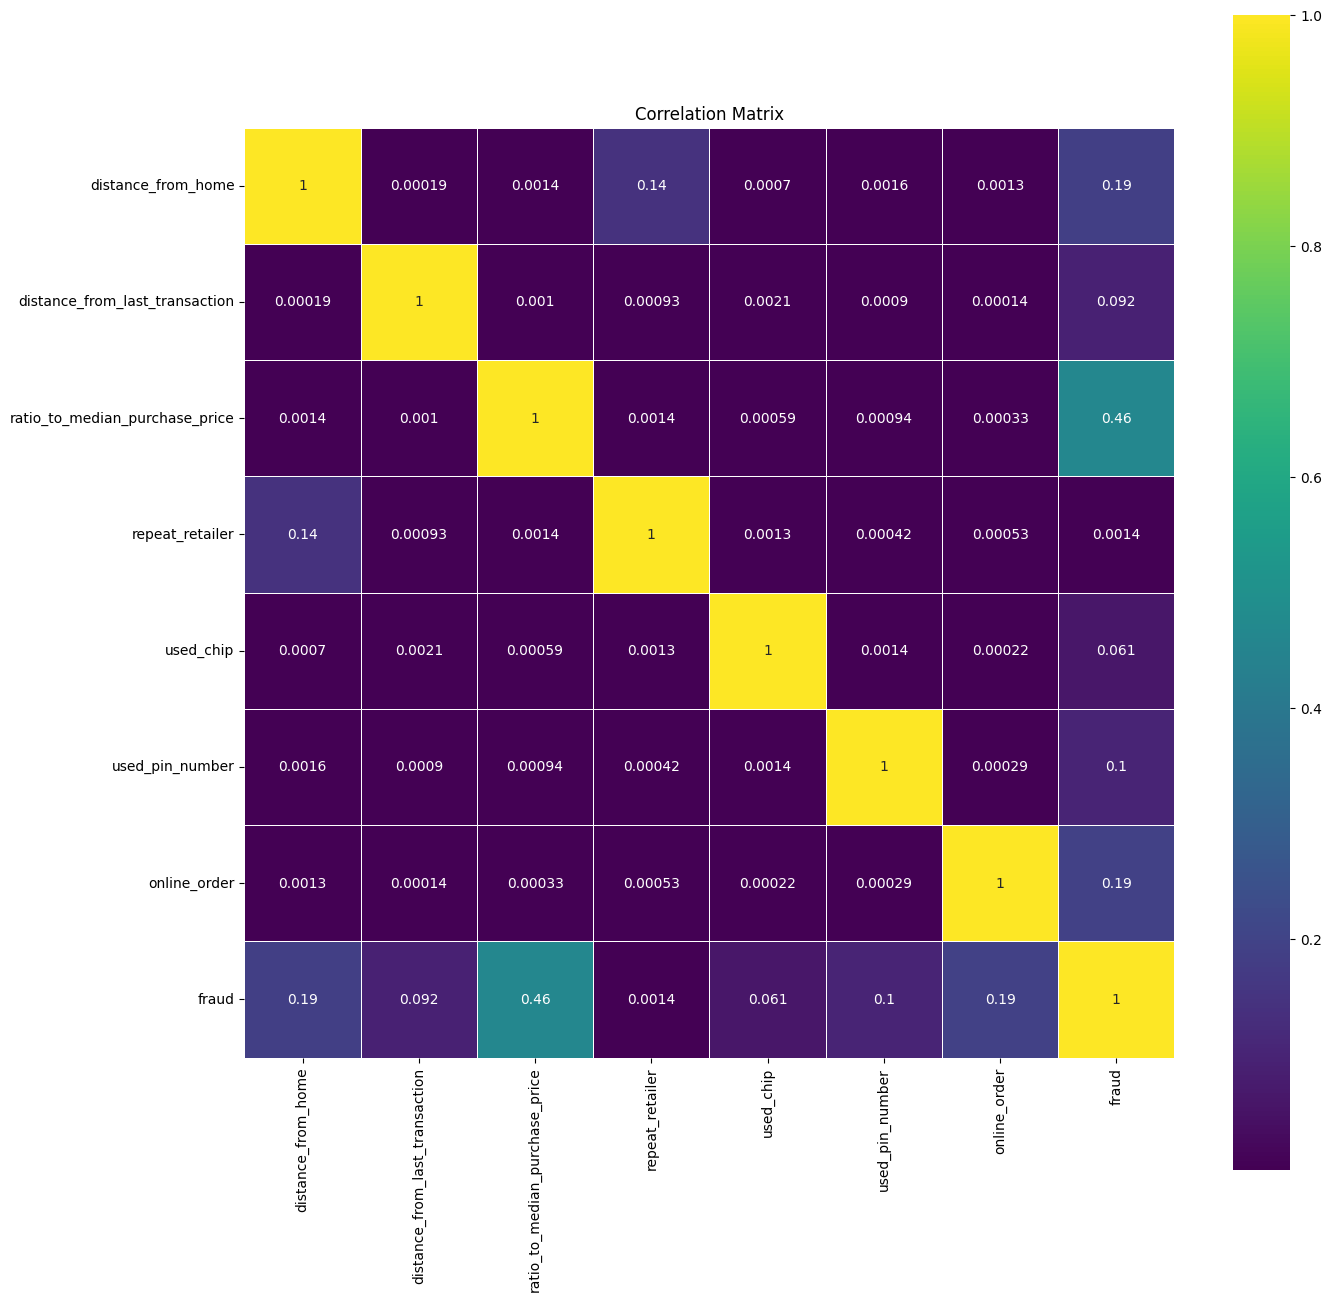

In [63]:
plt.figure(figsize = (15, 15))
plt.title("Correlation Matrix")
corr_matrix = df_credit_card_fraud_org.corr().abs()
sns.heatmap(corr_matrix, annot=True, robust=True, cmap="viridis", linewidths=0.5, square=True)
plt.show()

In [65]:
sns.pairplot(df_credit_card_fraud_org[df_credit_card_fraud_org.columns], diag_kind='kde', hue='fraud')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x791e3043fa30> (for post_execute):


KeyboardInterrupt: 